# Sea ice and mesoscale cyclones in ERA5

In [1]:
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
from pathlib import Path
import string
import xarray as xr
from tqdm import tqdm_notebook as tqdm

from arke.cart import lcc_map, lcc_map_grid

from common_defs import winters, nyr, winter_dates
from plot_utils import LCC_KW, trans, clev101, abs_plt_kw, iletters
import mypaths

from octant.core import TrackRun, OctantTrack, HOUR
from octant.misc import calc_all_dens, SUBSETS, DENSITY_TYPES
import octant
octant.__version__

'0.0.11'

In [2]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='dask')
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')
warnings.filterwarnings('ignore', category=UserWarning, module='iris')

In [3]:
plt.style.use('paperfig.mplstyle')

In [4]:
lsm = xr.open_dataarray(mypaths.era5_dir / 'lsm.nc').squeeze()
lsm.attrs['units'] = 1
lon2d, lat2d = np.meshgrid(lsm.longitude, lsm.latitude)

In [5]:
lsm_subset = lsm[(lsm.latitude >= 65) & (lsm.latitude <= 85), (lsm.longitude >= -20) & (lsm.longitude <= 50)]

### Get area weights to calculate the sea ice area

#### Calculate area weights using iris

In [6]:
import iris
from cf_units import Unit

In [7]:
lsm_cube = lsm.to_iris()

In [8]:
lsm_cube.coord('longitude').guess_bounds()
lsm_cube.coord('latitude').guess_bounds()

In [9]:
weights = lsm_cube.copy(data=iris.analysis.cartography.area_weights(lsm_cube, normalize=False))
weights.units = Unit('m^2')
weights.rename('area_weights')

Convert weights to $km^2$

In [10]:
weights.convert_units('km^2')

Convert to xarray dataarray

In [11]:
area_w = xr.DataArray.from_iris(weights)
area_w = area_w[(area_w.latitude >= 65) & (area_w.latitude <= 85), (area_w.longitude >= -20) & (area_w.longitude <= 50)]

## Load sea ice data

In [12]:
sea_ice_ds = xr.open_mfdataset(sorted(mypaths.era5_dir.glob('*.ci.nc')))

Extract sea ice cover array within the area used for tracking ($65-85N, 20W-50E$)

In [13]:
sea_ice_conc = sea_ice_ds.ci[:, (sea_ice_ds.latitude >= 65) & (sea_ice_ds.latitude <= 85), (sea_ice_ds.longitude >= -20) & (sea_ice_ds.longitude <= 50)]

### Sea ice area

By multiplying sea-ice cover variable from ERA5 by the area weights we obtain the **sea ice area**.

Note: this is not a sea ice extent, see http://nsidc.org/arcticseaicenews/faq/#area_extent.

In [14]:
sic_thresh = 0.15  # 15% threshold

In [15]:
sea_ice_area = (sea_ice_conc * area_w).where(sea_ice_conc > sic_thresh, 0.)
# sea_ice_extent = (sea_ice_conc * 0.).where(sea_ice_conc < sic_thresh, 1.) * area_w

Get month numbers for each time step

In [16]:
month_series = sea_ice_area.time.dt.month

Create a boolen Dataaray that is true only during winter

In [17]:
extended_winter_mask = (month_series <= 4) | (month_series >= 10)

Mask the values not in winter and resample annualy starting in october

In [18]:
sea_ice_area_winter_mean = sea_ice_area.where(extended_winter_mask).resample(time='as-oct').mean('time')

In [19]:
sea_ice_conc_winter_mean = sea_ice_conc.where(extended_winter_mask).resample(time='as-oct').mean('time')

Add winter labels as an auxiliary coordinate

In [20]:
sea_ice_area_winter_mean['winter'] = ('time', winters)

In [21]:
total_sea_ice_area_over_winters = sea_ice_area_winter_mean.sum(dim=('longitude', 'latitude')) * 1e-6

### Calculate linear regression coeffiecients

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lr_model = LinearRegression(fit_intercept=True)

In [24]:
x = np.array(range(total_sea_ice_area_over_winters.shape[0]))

In [25]:
lr_model.fit(x[:, np.newaxis], total_sea_ice_area_over_winters.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
sia_trend = lr_model.predict(x[:, np.newaxis])

In [27]:
print(f'Sea ice area decrease per year [10^6 km^2]: {lr_model.coef_[0]:4.3f}')

Sea ice area decrease per year [10^6 km^2]: -0.025


In [28]:
xlabels = [i.replace('_', '-') for i in total_sea_ice_area_over_winters.winter.values]

In [29]:
# min_idx = total_sea_ice_area_over_winters.argmin(dim='time').values
# winter_min = str(total_sea_ice_area_over_winters.winter[min_idx].values)
# max_idx = total_sea_ice_area_over_winters.argmax(dim='time').values
# winter_max = str(total_sea_ice_area_over_winters.winter[max_idx].values)

In [30]:
## Select winters with extreme sea ice concentration
# sia_minimum = sea_ice_area_winter_mean[sea_ice_area_winter_mean.winter==winter_min].squeeze()
# sia_maximum = sea_ice_area_winter_mean[sea_ice_area_winter_mean.winter==winter_max].squeeze()

In [31]:
# ci_minimum = sea_ice_conc_winter_mean[sea_ice_area_winter_mean.winter==winter_min].squeeze()
# ci_maximum = sea_ice_conc_winter_mean[sea_ice_area_winter_mean.winter==winter_max].squeeze()

## Load tracks

In [32]:
# dataset = 'era5'

In [33]:
# TR = TrackRun()
# TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / 'era5_run000_2008_2017.parquet', engine='pyarrow'))

In [34]:
# TR_seaice_min = TrackRun()
# TR_seaice_min.data = TR.data[(TR.data['time'] >= winter_dates[winter_min][0]) & (TR.data['time'] <= winter_dates[winter_min][1])]

In [35]:
# TR_seaice_max = TrackRun()
# TR_seaice_max.data = TR.data[(TR.data['time'] >= winter_dates[winter_max][0]) & (TR.data['time'] <= winter_dates[winter_max][1])]

## Is the sea ice trend significant? Here we check this using a nonparametric resampling procedure (Monte Carlo method).

### Sea ice trend

In [36]:
import itertools as it
from math import factorial
from numpy.polynomial import polynomial as P

In [37]:
# def permutation_matrix(k):
#     f_k = math.factorial(k)
#     A = np.empty((k, f_k))
#     for i, perm in enumerate(it.permutations(range(k))):
#         A[:, i] = perm
#     return A

In [38]:
ci = total_sea_ice_area_over_winters.values

In [39]:
ci

array([0.94120279, 0.88284433, 0.95311772, 0.75642094, 0.82125429,
       0.77231725, 0.89237125, 0.68322642, 0.74785617])

In [40]:
(real_intercept, real_slope) = P.polyfit(np.arange(9), ci, 1)

In [41]:
perm_mat = np.array([*it.permutations(ci)])

In [42]:
(intercepts, slopes) = P.polyfit(np.arange(nyr), perm_mat.T, 1)

np.random.shuffle(slopes)

In [43]:
real_slope

-0.02463061373797954

### Resulting plot

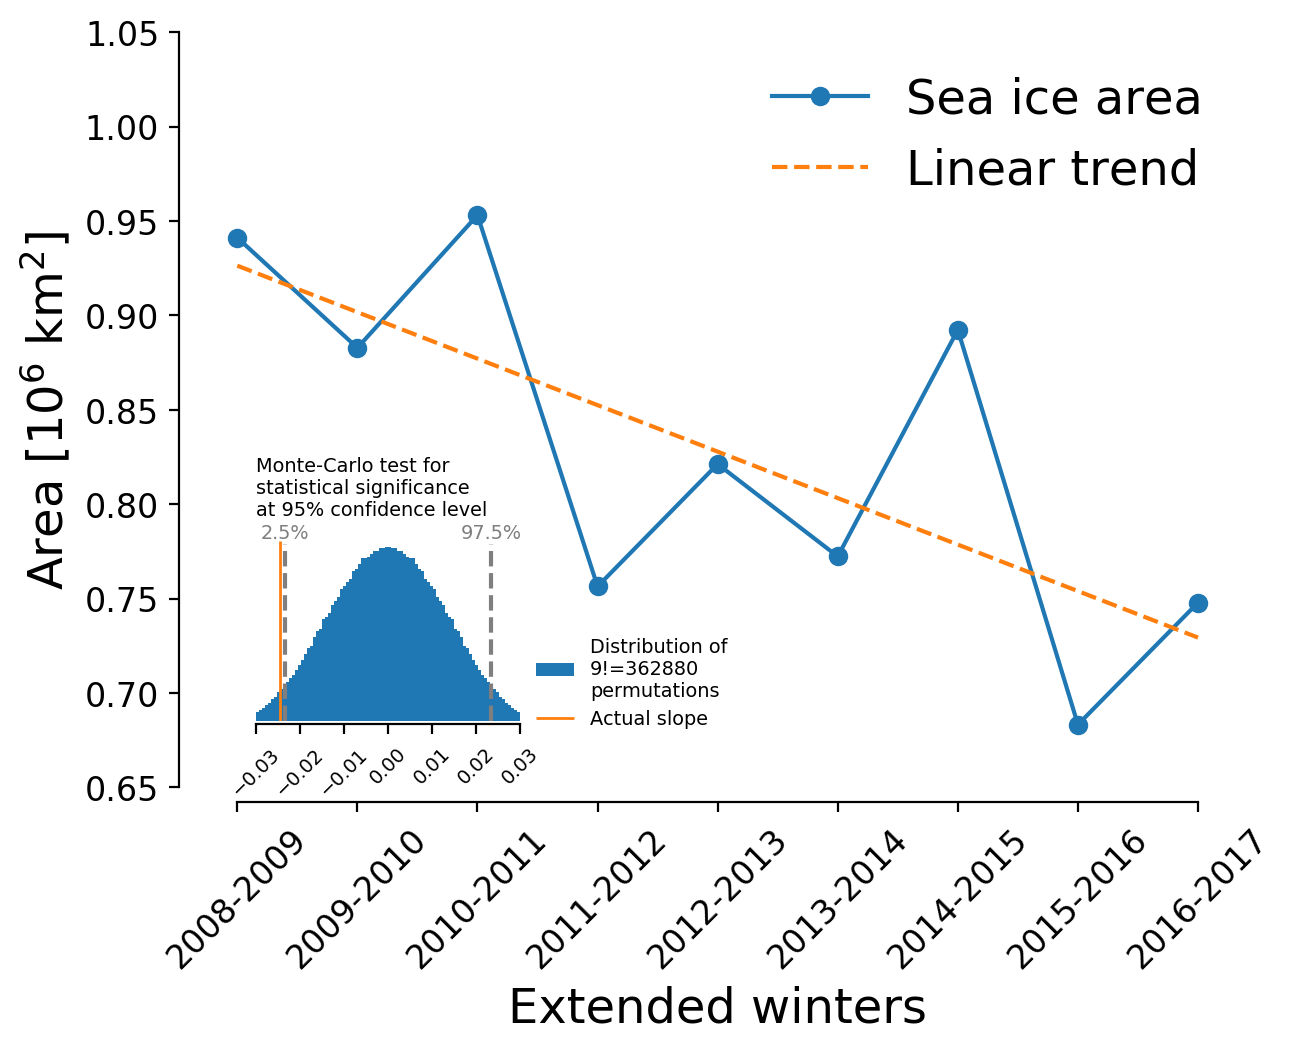

In [44]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
ax.plot(xlabels, total_sea_ice_area_over_winters, marker='o', color='C0', label='Sea ice area')
ax.plot(xlabels, sia_trend, color='C1', linestyle='--', label='Linear trend')
# ax.plot(xlabels[max_idx], total_sea_ice_area_over_winters[max_idx], marker='o', mec='#333333', mfc='C3', ms=10)
# ax.plot(xlabels[min_idx], total_sea_ice_area_over_winters[min_idx], marker='o', mec='#333333', mfc='C0', ms=10)
ax.legend(loc='upper right',          
          frameon=False,
          fontsize='x-large')

ax.set_yticks(np.arange(0.65, 1.1, 0.05))
ax.spines['bottom'].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_bounds(ax.get_yticks()[0], ax.get_yticks()[-1])
ax.spines['left'].set_position(('axes', -0.01))

ax.set_xlabel('Extended winters', fontsize='x-large')
ax.set_ylabel('Area [$10^6$ $km^2$]', fontsize='x-large')
ax.tick_params(axis='x', rotation=45)
# ax.add_artist(AnchoredText('a', loc=3, prop=dict(size='large')))



inax = inset_axes(ax,
                  borderpad=1.5,
                  width="25%",
                  height="25%",
                  loc='lower left')
inax.patch.set_alpha(0.)
inax.hist(slopes, density=False, bins=100, label=f'Distribution of\n{nyr}!={len(slopes)}\npermutations')
# ax.hist(slopes[:sub_n], density=True, bins=100, color='C2', label=f'Distribution of {sub_n} permutations')
inax.spines['left'].set_visible(False)
inax.spines['bottom'].set_position(('axes', -0.02))
inax.set_xticks(np.arange(-0.030, 0.031, 0.01))
inax.set_xlim(-0.03, 0.03)
inax.set_yticks([])
inax.tick_params(labelsize='xx-small', rotation=45)

ymax = inax.get_ylim()[-1]

# # for perc in (1, 2.5, 5, 50, 95, 97.5, 99):
for perc in [2.5, 97.5]:
    x = np.percentile(slopes[:], perc)
    inax.vlines(x, 0, ymax-250, color='C7', linestyle='--')
    inax.annotate(f'{perc}%',
                  (x, ymax+250),
                  ha='center', va='center',
                  color='C7',
                  size='xx-small')

inax.vlines(real_slope, 0, ymax-100, color='C1', linewidth=1, label='Actual slope')
inax.legend(loc='right', fontsize='xx-small', bbox_to_anchor=(1.85, 0.2), frameon=False)

inax.set_title('Monte-Carlo test for\nstatistical significance\nat 95% confidence level', loc='left', fontsize='xx-small')

fig.savefig(mypaths.plotdir / 'sea_ice_trend')

The "real" slope of the sea ice series linear regression is significant with 95% confidence.

### Maps

#### Grids and arrays for density calculation

In [45]:
lon_dens = np.arange(-20, 51, 1.)
lat_dens = np.arange(65, 86, 1.)
lon_dens, lat_dens = np.meshgrid(lon_dens, lat_dens)

In [46]:
lsm_1deg = lsm[(lsm.latitude >= 65) & (lsm.latitude <= 85), (lsm.longitude >= -20) & (lsm.longitude <= 50)].interp(coords=dict(longitude=lon_dens[0, :], latitude=lat_dens[:, 0])).to_iris()
lsm_1deg.coord('longitude').units = Unit('degrees_east')
lsm_1deg.coord('latitude').units = Unit('degrees_north')
lsm_1deg.coord('longitude').guess_bounds()
lsm_1deg.coord('latitude').guess_bounds()

In [47]:
weights = lsm_1deg.copy(data=iris.analysis.cartography.area_weights(lsm_1deg, normalize=False))
weights.units = Unit('m^2')
weights.rename('area_weights')
weights.convert_units('km^2')

In [48]:
area_weights_1deg = xr.DataArray.from_iris(weights)

In [49]:
area_weights_1deg_norm = xr.DataArray.from_iris(lsm_1deg.copy(data=iris.analysis.cartography.area_weights(lsm_1deg, normalize=True)))

In [50]:
lsm_1deg = xr.DataArray.from_iris(lsm_1deg)

### What about linear trend significance at each grid point?

In [51]:
nperm = 10000

In [52]:
sea_ice_area_winter_mean = sea_ice_area_winter_mean.interp(coords=dict(longitude=lon_dens[0, :], latitude=lat_dens[:, 0]))

In [53]:
def lin_regres_each_grid_point(xarr, nperm=0, dim='time'):
    
    name = 'slope_of_linear_regression'
    if xarr.name is not None:
        name += f'_of_{xarr.name}'        
    
    nt = xarr.sizes[dim]
    x = np.arange(nt)
    
    rest_shape = tuple([xarr.sizes[k] for k in xarr.dims if k != dim])
    rest_coord_names = tuple([k for k in xarr.dims if k != dim])
    
    xarr2d = xarr.values.reshape(nt, -1)
    dim1_len = xarr2d.shape[1]
    
    if nperm == 0:
        (intercept, slope) = P.polyfit(x, xarr2d, deg=1)
        slopes_array = slope.reshape(rest_shape)
        coords = [xarr.coords[coord_name] for coord_name in rest_coord_names]
    else:        
#         xarr2d = xarr2d.repeat(nperm).reshape(nt, dim1_len * nperm)
        perm_mat = np.full((nperm, nt, dim1_len), np.nan)
        for i in range(nperm):
            # shuffle slices thus creating a stack of shuffled copies
            perm_mat[i, ...] = np.random.permutation(xarr2d)
        perm_mat = np.rollaxis(perm_mat, 0, 3).reshape(nt, -1)

        slopes_array = np.linalg.lstsq(np.vander(x, 2), perm_mat, rcond=None)[0][0]
        slopes_array = slopes_array.T.reshape(*rest_shape, nperm)
        slopes_array = np.rollaxis(slopes_array, -1, 0)

        coords = [xr.IndexVariable(dims='perm', data=np.arange(nperm))]
        coords += [xarr.coords[coord_name] for coord_name in rest_coord_names]
    
    return xr.DataArray(slopes_array, coords=coords, name=name)

In [54]:
seaice_actual_slope = lin_regres_each_grid_point(sea_ice_area_winter_mean)

In [55]:
seaice_slopes = lin_regres_each_grid_point(sea_ice_area_winter_mean, nperm=nperm)

In [56]:
seaice_slopes = seaice_slopes.where(~(seaice_slopes == 0).all(dim='perm'), np.nan)

In [ ]:
seaice_regres_confidence_mask = ((  (seaice_actual_slope <= np.percentile(seaice_slopes, 5, axis=0))
                                  | (seaice_actual_slope >= np.percentile(seaice_slopes, 95, axis=0))) & (lsm_1deg.values < 1)).astype(int)

### Load tracks

In [58]:
dataset = 'era5'

In [59]:
TR = TrackRun()
TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / 'era5_run000_2008_2017_top10.parquet', engine='pyarrow'))

#### Winter-average density

In [60]:
TR_one_winter = TrackRun()

_d = dict()
for winter, (winter_start, winter_end) in tqdm(winter_dates.items(), desc='winters'):
    TR_one_winter.data = TR.data[(TR.data['time'] >= winter_start) & (TR.data['time'] <= winter_end)]
    _d[winter] = calc_all_dens(TR_one_winter, lon_dens, lat_dens, method='radius', r=111.3)
dens_per_winter = xr.Dataset(_d).to_array(dim='winter').rename('density')
clear_output()

In [61]:
da = dens_per_winter.sel(subset='moderate', dens_type='track')

In [62]:
actual_slope = lin_regres_each_grid_point(da, dim='winter')

In [63]:
slopes = lin_regres_each_grid_point(da, nperm=nperm, dim='winter')
slopes = slopes.where(~(slopes == 0).all(dim='perm'), np.nan)

In [ ]:
regres_confidence_mask = ((  (actual_slope <= np.percentile(slopes, 5, axis=0))
                           | (actual_slope >= np.percentile(slopes, 95, axis=0))) & (lsm_1deg.values < 1)).astype(int)

In [65]:
data2plot = [
    (seaice_actual_slope, seaice_regres_confidence_mask),
    (actual_slope, regres_confidence_mask)
]

### The two maps

In [66]:
AXGR_KW = dict(axes_pad=0.2)
slope_kw = dict(cmap='RdBu_r', robust=False, add_colorbar=False, add_labels=False, **trans)
conf_mask_kw = dict(levels=[0, 0.5, 1.1], colors='none', hatches=[None, '....'], add_labels=False, add_colorbar=False, **trans)

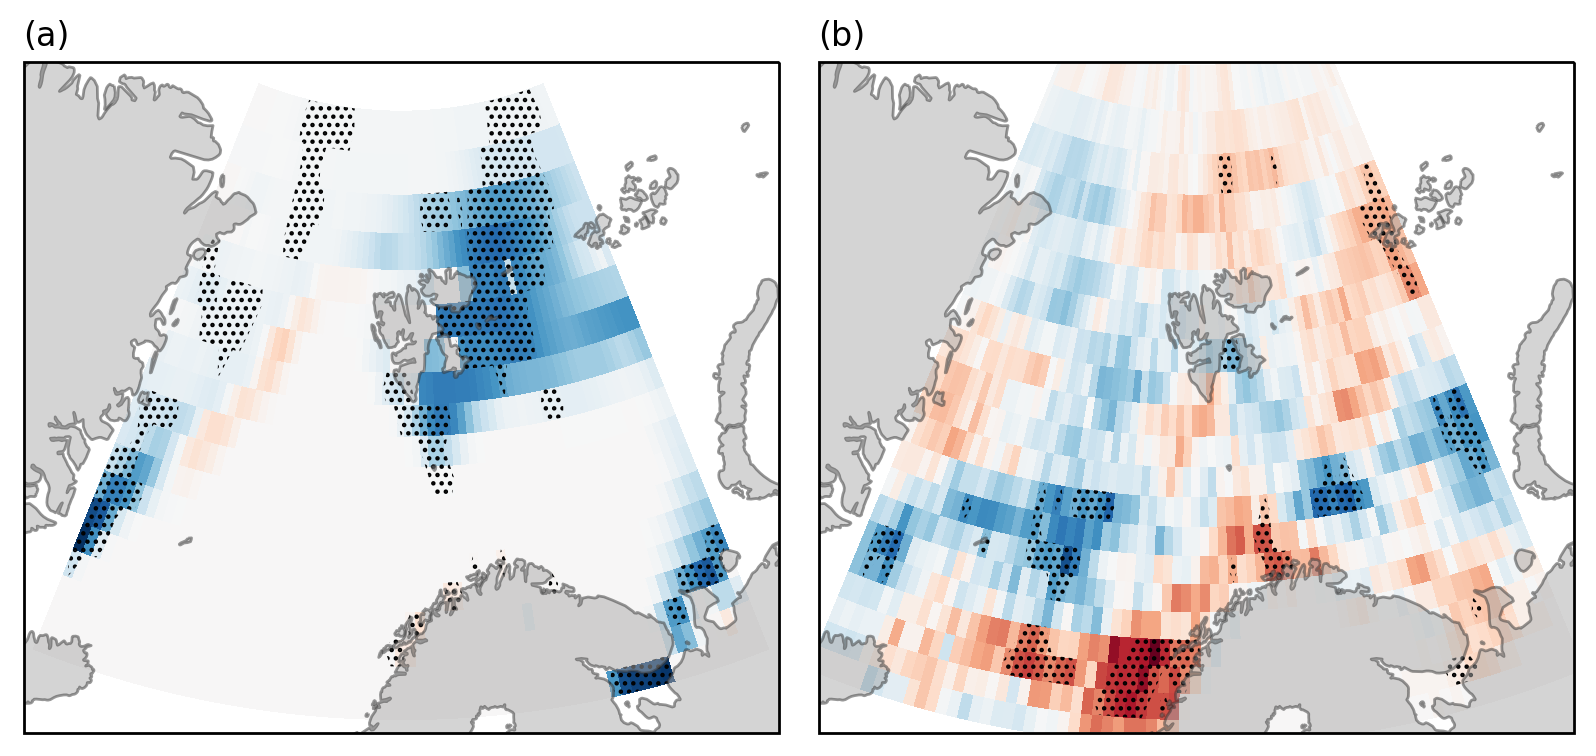

In [67]:
ncol = 2
nrow = 1

iletters = iter(string.ascii_lowercase)

fig = plt.figure(figsize=(ncol*5, nrow*5))
axgr = lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

for (ax, (_slope, _conf_mask)) in zip(axgr.axes_all, data2plot):
    ax.set_title(f'({next(iletters)})', loc='left', fontsize='medium')
    _slope.plot.pcolormesh(ax=ax, rasterized=True, **slope_kw)
    _conf_mask.plot.contourf(ax=ax, **conf_mask_kw)
    
fig.savefig(mypaths.plotdir / 'seaice_and_era5_moderate_track_density_map')

## Comparing two extreme winters

In [74]:
# da = dens_per_winter.sel(subset='moderate', dens_type='point')
da = dens_per_winter

In [75]:
pair_combinations = np.array([*it.combinations(winters, 2)])
pairs = [f'{j} minus {i}' for i, j in pair_combinations]

In [76]:
diffs = xr.DataArray(np.zeros((len(pair_combinations), *[j for i, j in da.sizes.items() if i != 'winter'])),
                     coords=(xr.IndexVariable(dims='winter_diff', data=pairs), da.subset, da.dens_type, da.latitude, da.longitude),
                     name='cyclone_density_difference')

In [77]:
# diffs = np.zeros((len(pair_combinations), *[j for i, j in da.sizes.items() if i != 'winter']))
for (winter0, winter1), winter_diff in zip(pair_combinations, pairs):
    diffs.sel(winter_diff=winter_diff)[:] = da.sel(winter=winter1) - da.sel(winter=winter0)
    #     diffs.i = da.values[idx1, ...] - da.values[idx0, ...]

In [78]:
actual_diff = diffs.sel(winter_diff=f'{winter_min} minus {winter_max}')

In [79]:
actual_confidence_mask = (((actual_diff <= np.percentile(diffs, 2.5, axis=0)) | (actual_diff >= np.percentile(diffs, 97.5, axis=0))) & (lsm_1deg.values < 1)).astype(int)
actual_confidence_mask.sel(subset='moderate', dens_type='lysis').sum()

<xarray.DataArray 'cyclone_density_difference' ()>
array(31)
Coordinates:
    winter_diff  <U25 '2015_2016 minus 2010_2011'
    subset       <U8 'moderate'
    dens_type    <U7 'lysis'

In [80]:
sel_kw = dict(subset='moderate', dens_type='genesis')

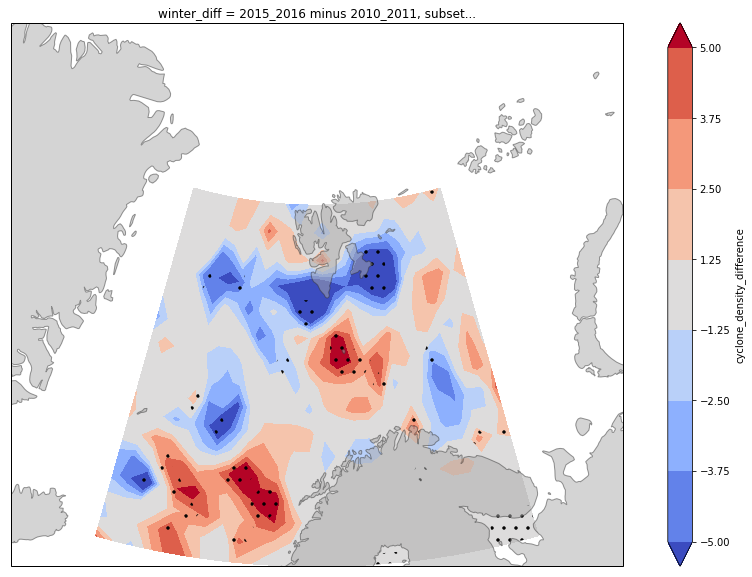

In [81]:
fig = plt.figure(figsize=(16, 10))

ax = lcc_map(fig, **LCC_KW)

actual_diff.sel(**sel_kw).plot.contourf(ax=ax, levels=clev101*round(np.percentile(actual_diff.sel(**sel_kw), 98)), extend='both', cmap='coolwarm', **trans)

actual_confidence_mask.sel(**sel_kw).plot.contourf(ax=ax, levels=[0, 0.5, 1.1], colors='none', hatches=[None, '.'], add_labels=False, add_colorbar=False, **trans)

### Field significance

In [82]:
null_dist_f = []

for i, d in enumerate(diffs):
    confidence_mask = (( (d <= np.percentile(diffs, 2.5, axis=0)) | (d >= np.percentile(diffs, 97.5, axis=0)) ) & (lsm_1deg < 1)).astype(int)
#     null_dist_f[i] = (area_weights_1deg_norm * confidence_mask).sum()
    null_dist_f.append((area_weights_1deg_norm * confidence_mask).sum(dim=('longitude', 'latitude')))
null_dist_f = xr.concat(null_dist_f, dim='winter_diff')

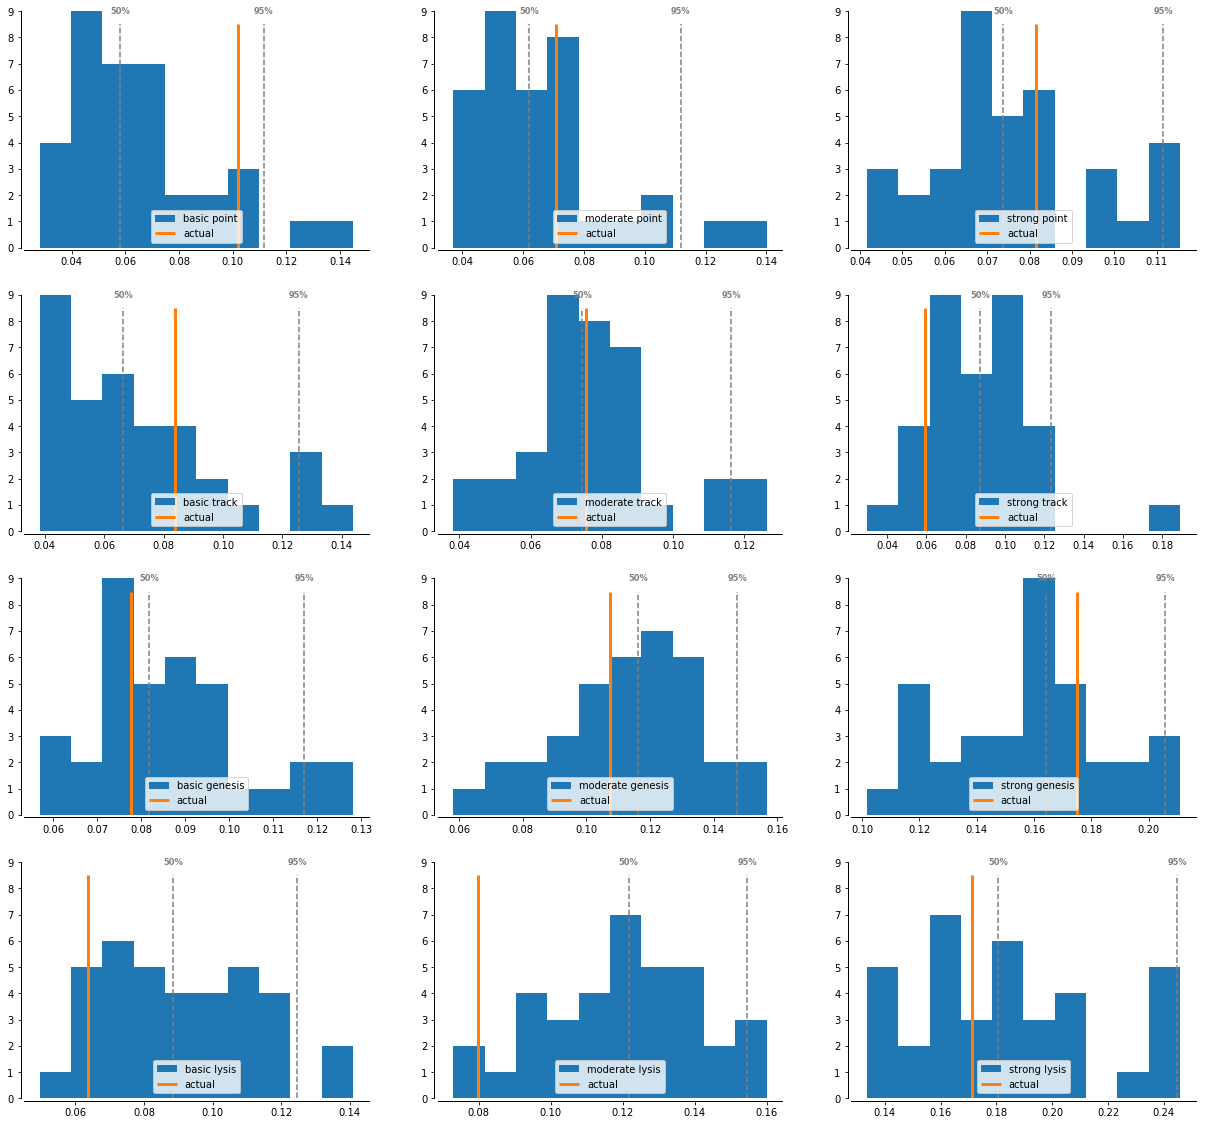

In [83]:
ncol = len(SUBSETS)
nrow = len(DENSITY_TYPES)


fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(7*ncol, 5*nrow))

for dens_type, axrow in zip(DENSITY_TYPES, axs):
    for subset, ax in zip(SUBSETS, axrow):
        sel_kw = dict(subset=subset, dens_type=dens_type)
        ax.hist(null_dist_f.sel(**sel_kw), label=f'{subset} {dens_type}')
        for spine in ax.spines.values():
            if spine.spine_type in ['top', 'right']:
                spine.set_linewidth(0)
            else:
                spine.set_linewidth(1)
        ax.spines['left'].set_position(('axes', -0.01))
        ax.spines['bottom'].set_position(('axes', -0.01))
#         ax.set_xticks(np.arange(0, 0.35, 0.05))
#         ax.set_xlim(0, 0.3)

        ymax = 9
        ax.set_ylim(0, ymax)

        for perc in (50, 95):
            x = np.percentile(null_dist_f.sel(**sel_kw), perc)
            ax.vlines(x, 0, ymax-0.5, color='C7', linestyle='--')
            ax.annotate(f'{perc}%', (x, ymax),
                        ha='center', va='center',
                        fontweight='bold',
                        color='C7',
                        size='small')

        ax.vlines(null_dist_f.sel(winter_diff=f'{winter_min} minus {winter_max}', **sel_kw), 0, ymax-0.5, color='C1', linewidth=3, label='actual')
        ax.legend(loc=8)

## Questions
* Autoregression
* Correlation
* Other tests?

In [95]:
np.tanh(1.96/6**0.5)

0.6641299261157337

## Plot density

In [45]:
AXGR_KW = dict(axes_pad=0.45,
               cbar_location='right',
               cbar_mode='each',
               cbar_pad=0.05,
               cbar_size='3%')

diff_plt_kw = dict(cmap='coolwarm', extend='both', **trans)
cntr_kw = dict(colors='#222222', linewidths=0.25, **trans)
cntr_lab_kw = dict(fmt='%3.0f', colors='k')
ci_kw = dict(levels=[0.15], linewidths=2, **trans)
at_kw = dict(loc=2, prop=dict(size='small'))

In [ ]:
subsets = SUBSETS[1:]

In [ ]:
ncol = len(subsets)
nrow = 4

for subset in subsets:
    fig = plt.figure(figsize=(ncol*7, nrow*5))
    axgr = lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

    ax_labels = iter(string.ascii_lowercase)
    cbar_ax_iter = iter(axgr.cbar_axes)
    for axrow, dens_type in tqdm(zip(axgr.axes_row, DENSITY_TYPES), leave=False):

        ax = axrow[0]
        txt = f'({next(iletters)}) Sea ice maximum\n{winter_max.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_max.sel(subset=subset, dens_type=dens_type), **abs_plt_kw)
        levels = h.get_array()
        hh = ax.contour(lon_dens, lat_dens, minmax_dens.dens_max.sel(subset=subset, dens_type=dens_type), levels=levels, **cntr_kw)
        hhh = ax.clabel(hh, **cntr_lab_kw)
        plt.setp(hhh, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground='w')])
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_maximum.plot.contour(ax=ax, add_labels=False, colors='C3', **ci_kw)

        ax = axrow[1]
        txt = f'({next(iletters)}) Sea ice minimum\n{winter_min.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_min.sel(subset=subset, dens_type=dens_type), levels=levels, **abs_plt_kw)
        hh = ax.contour(lon_dens, lat_dens, minmax_dens.dens_min.sel(subset=subset, dens_type=dens_type), levels=levels, **cntr_kw)
        hhh = ax.clabel(hh, **cntr_lab_kw)
        plt.setp(hhh, path_effects=[PathEffects.withStroke(linewidth=1.5, foreground='w')])
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_minimum.plot.contour(ax=ax, add_labels=False, colors='C9', **ci_kw)

        ax = axrow[2]
        txt = f'({next(iletters)}) Difference (min-max)\n{winter_min.replace("_", "-")} - {winter_max.replace("_", "-")}\n{dens_type} density'
        ax.add_artist(AnchoredText(txt, **at_kw))
        h = ax.contourf(lon_dens, lat_dens, minmax_dens.dens_diff.sel(subset=subset, dens_type=dens_type), **diff_plt_kw)
        cb = fig.colorbar(h, cax=next(cbar_ax_iter))
        # Overlay with sea ice edge
        ci_minimum.plot.contour(ax=ax, add_labels=False, colors='C9', **ci_kw)
        ci_maximum.plot.contour(ax=ax, add_labels=False, colors='C3', **ci_kw)

    # fig.savefig(mypaths.plotdir / f'pmctrack_{dataset}_seaice_minmaxdiff_density_{subset}')

We have data averaged over 2008-2017 extended winters, i.e. the sample size is 9.

If we want to look at the difference of cyclone density between 2 extreme winters, the total number of combinations is
$$9C_2=\frac{9!}{7!\cdot2!}=36$$

Next, we can calculate the difference for each of the combinations and derive a distribution of values.
If the "real" difference is smaller than the 5-percentile or larger than 95-percentile (in the tails), it can be regarded as significant.

This is a test for **local** significance, which can be calculated at each grid point.
What about field significance?